In [7]:
import tqdm as tqdm
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.layers.convolutional import *
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.python.keras.utils.np_utils import to_categorical
from torchvision.transforms import transforms

In [8]:
#!python3 -m pip install opencv-python==4.6.0.66

In [9]:
#data processing
def read_and_resize(filename, grayscale = False, fx= 0.5, fy=0.5):
    if grayscale:
        img_result = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    else:
        imgbgr = cv2.imread(filename, cv2.IMREAD_COLOR)
        # convert to rgb
        img_result = cv2.cvtColor(imgbgr, cv2.COLOR_BGR2RGB)
    # resize
    img_result = cv2.resize(img_result, None, fx=fx, fy=fy, interpolation = cv2.INTER_CUBIC)
    return img_result

def show_in_row(list_of_images, titles = None, disable_ticks = False):
    count = len(list_of_images)
    for idx in range(count):
        subplot = plt.subplot(1, count, idx+1)
        if titles is not None:
            subplot.set_title(titles[idx])

        img = list_of_images[idx]
        cmap = 'gray' if (len(img.shape) == 2 or img.shape[2] == 1) else None
        subplot.imshow(img, cmap=cmap)
        if disable_ticks:
            plt.xticks([]), plt.yticks([])
    plt.show()

path = "./data/data/garbage/"

deIdx = {1:"glass", 2:"paper", 3:"cardboard", 4:"plastic", 5:"metal"}

testTxt = "one-indexed-files-notrash_test.txt"
trainTxt = "one-indexed-files-notrash_train.txt"
valTxt = "one-indexed-files-notrash_val.txt"

def openWithTxt(txt: str, path:str):
    outData = []
    with open("./data/"+txt) as f:
        for i in f.readlines():
            img ,classNum = i.split()
            outData.append(np.array([read_and_resize(path+f"{classNum}/"+img).astype("float32")/255, int(classNum)]))
    return np.array(outData)

In [10]:
testData = openWithTxt(testTxt, path)
xTest = np.stack(testData[:,0])
yTest =  to_categorical(testData[:,1],num_classes = len(deIdx.values())+2)[:,1:]
testData.shape

/var/folders/2_/tfp3lycn2ynch__lcz9zz6jc0000gp/T/ipykernel_52178/1342351137.py:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  outData.append(np.array([read_and_resize(path+f"{classNum}/"+img).astype("float32")/255, int(classNum)]))


(431, 2)

In [11]:
trainData = openWithTxt(trainTxt, path)
xTrain = np.stack(trainData[:,0])
yTrain = to_categorical(trainData[:,1],num_classes = len(deIdx.values())+2)[:,1:]
trainData.shape

/var/folders/2_/tfp3lycn2ynch__lcz9zz6jc0000gp/T/ipykernel_52178/1342351137.py:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  outData.append(np.array([read_and_resize(path+f"{classNum}/"+img).astype("float32")/255, int(classNum)]))


(1768, 2)

In [12]:
valData = openWithTxt(valTxt, path)
xVal = np.stack(valData[:,0])
yVal = to_categorical(valData[:,1],num_classes = len(deIdx.values())+2)[:,1:]
valData.shape

/var/folders/2_/tfp3lycn2ynch__lcz9zz6jc0000gp/T/ipykernel_52178/1342351137.py:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  outData.append(np.array([read_and_resize(path+f"{classNum}/"+img).astype("float32")/255, int(classNum)]))


(328, 2)

/usr/local/lib/python3.9/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


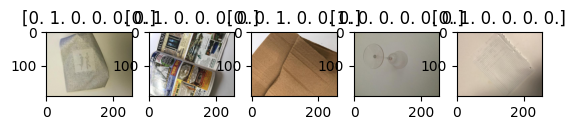

In [13]:
show_in_row(xTest[:5], yTest[:5])

In [7]:
z = np.array([[1,2],[3,4]])
z[:,0]

array([1, 3])

# Model 1

##  CNN (keras)


In [8]:
img = xVal[0]
imgShape = img.shape
imgShape

(192, 256, 3)

# model

In [9]:
from keras.optimizer_v2.adam import Adam

kernelSize = (3, 3)
model = Sequential()
model.add(Conv2D(16, kernelSize, input_shape=imgShape, padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(Conv2D(32, kernelSize, padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(Conv2D(16, kernelSize, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.005, clipvalue=5))

2022-10-05 11:10:05.359000: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
xTrain.shape

(1768, 192, 256, 3)

In [ ]:
model.fit(xTrain, yTrain, validation_data=(xVal, yVal), epochs=5, batch_size=512)
model.save_weights("kek.hdf5")
acc = model.evaluate(xTest, yTest)[1]*100
print("Accuracy: &2.f%%" %(acc))

Epoch 1/5


In [1]:
!pip3 install torch torchvision torchaudio

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.8/133.8 MB 4.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 5.6 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 5.5 MB/s eta 0:00:0000:0100:01
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and w

# model pytorch

In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=(1,1))
        self.conv2 = nn.Conv2d(32, 128, 3, padding=(1,1))
        self.conv3 = nn.Conv2d(128, 16, 3, padding=(1,1))
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(16 * 96 * 128, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 6)

    def forward(self, x):
        x = self.dropout(F.relu(self.conv1(x)))
        x = self.dropout(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        #print(x.shape)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
#torch.Size([4, 16, 96, 128])

net = Net()

In [55]:
xTrain.shape

(1768, 192, 256, 3)

In [56]:
from torch.utils.data import Dataset

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

batch_size = 4

class MyData(Dataset):
    def __init__(self, x, y, transform):
        self.x = x
        self.y = y
        self.transform = transform
        self.len = len(x)
        self.to_tensor = transforms.ToTensor()
    def __len__(self):
        return self.len
    def __getitem__(self, item):
        #print(type(self.x[item]))
        return self.transform(self.x[item]), torch.from_numpy(self.y[item])

myDataTrain = MyData(xTrain,yTrain, transform)
myDataVal = MyData(xVal,yVal, transform)
myDataTest = MyData(xTest,yTest, transform)

dataTrain = torch.utils.data.DataLoader(myDataTrain, batch_size=batch_size)
dataVal = torch.utils.data.DataLoader(myDataVal, batch_size=batch_size)
dataTest = torch.utils.data.DataLoader(myDataTest, batch_size=batch_size)

In [77]:
from tqdm import tqdm
import torch.optim as optim
model = net

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(epoch, model, dataTrain, criterion, optimizer ):
    running_loss = 0.0
    model.train()
    for i, data in tqdm(enumerate(dataTrain)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss}')
        running_loss = 0.0

def test(model, dataTest, criterion):
    model.eval()
    truePos = 0.0
    running_loss = 0.0
    for i, data in tqdm(enumerate(dataTest)):
        inputs, labels = data

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * labels.shape[0]
        truePos += (outputs.argmax(1) == labels.argmax(1)).sum()
    print(truePos)
    acc = truePos/len(dataTest.dataset)
    tLoss = running_loss / len(dataTest.dataset)
    print("acc:",acc, "loss:", tLoss)

In [78]:
test(model, dataTest, criterion)

108it [00:18,  5.98it/s]

tensor(240.)
acc: tensor(0.5568) loss: 1.993953089426399


In [74]:
len(dataTest.dataset)

431

In [99]:
list(dataTest)[2][1]

tensor([[1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.]])

In [100]:
model(list(dataTest)[2][0]).argmax(1)

tensor([0, 0, 2, 0])

In [96]:
list(dataTest)[2][0][1].shape

array([[[0.7882353 , 0.78039217, 0.78039217, ..., 0.84313726,
         0.84313726, 0.84313726],
        [0.79607844, 0.7882353 , 0.7882353 , ..., 0.84313726,
         0.84313726, 0.84313726],
        [0.8117647 , 0.8039216 , 0.8039216 , ..., 0.84313726,
         0.84313726, 0.84313726],
        ...,
        [0.8039216 , 0.8039216 , 0.8039216 , ..., 0.88235295,
         0.88235295, 0.88235295],
        [0.8039216 , 0.8039216 , 0.8039216 , ..., 0.88235295,
         0.88235295, 0.88235295],
        [0.8039216 , 0.8039216 , 0.8039216 , ..., 0.88235295,
         0.88235295, 0.88235295]],

       [[0.73333335, 0.7176471 , 0.70980394, ..., 0.7647059 ,
         0.7647059 , 0.7647059 ],
        [0.7254902 , 0.7176471 , 0.7176471 , ..., 0.7647059 ,
         0.7647059 , 0.7647059 ],
        [0.7254902 , 0.7176471 , 0.7176471 , ..., 0.7647059 ,
         0.7647059 , 0.7647059 ],
        ...,
        [0.69411767, 0.69411767, 0.69411767, ..., 0.79607844,
         0.79607844, 0.79607844],
        [0.6

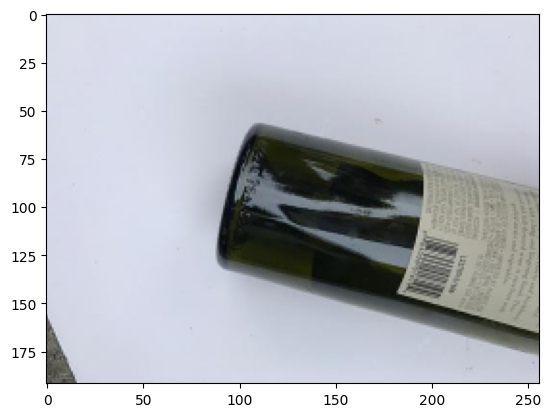

In [101]:
show_in_row([xTest[12]])